# Introduction to Financial Engineering [IE471]
##  Hands-on Practice on Financial AI Session #1

### 1. Import Packages
#### Please import pandas_datareader package using 'pip install pandas_datareader'.

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

import pytorch_lightning as pl # Use Pytorch Lightning

def dummy_trainloader():
    tl = DataLoader(TensorDataset(torch.Tensor(1), torch.Tensor(1)), batch_size=1)
    return tl

plt.style.use('ggplot')

device = torch.device('cpu') # declare device

### 2. Loading the Dataset

In [2]:
start = (2000, 1, 1)  # 2000-01-01 
start_time = datetime.datetime(*start)  
end = (2020, 12, 31) # 2020-12-31
end_time = datetime.datetime(*end) 

# Loading Samsung Electronic Co,. Ltd. (KS: 005930) Data from Yahoo Finance
df = pdr.DataReader('005930.KS', 'yahoo', start_time, end_time)

High : HIgh Price, The highest price at which a stock traded during that particular day

Low : Low Price, The lowest price at which a stock traded during that particular day

Open : Open Price, The stock price at which opens at the start of market

Close : Close Price, The stock closing at the end of the market hours

Volume : Trading volume during that particular day

Adj Close : A stock's closing price to reflect that stock's value after accounting for any corporate actions (Reference: https://help.yahoo.com/kb/SLN28256.html)

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-04,6110.0,5660.0,6000.0,6110.0,74195000.0,4761.183105
2000-01-05,6060.0,5520.0,5800.0,5580.0,74680000.0,4348.184082
2000-01-06,5780.0,5580.0,5750.0,5620.0,54390000.0,4379.354004
2000-01-07,5670.0,5360.0,5560.0,5540.0,40305000.0,4317.015625
2000-01-10,5770.0,5580.0,5600.0,5770.0,46880000.0,4496.240723


In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-23,74000.0,72300.0,72400.0,73900.0,19411326.0,72085.835938
2020-12-24,78800.0,74000.0,74100.0,77800.0,32502870.0,75890.093750
2020-12-28,80100.0,78200.0,79000.0,78700.0,40085044.0,76768.000000
2020-12-29,78900.0,77300.0,78800.0,78300.0,30339449.0,78300.000000
2020-12-30,81300.0,77300.0,77400.0,81000.0,29417421.0,81000.000000


In [5]:
X = df # Using high price, low price, Open price, Close price, Volume, and Adjusted Close Price to predict adjusted close price
y = df.iloc[:, 5:6] #Predicting adjusted close price

### 3. Scaling and Converting Data

We can see that there is a big difference between volume and other values. In this case, GRU models need to recognize the difference between these two scales: volume and the rest values, which can be a burden to train data. Therefore, we reduce by scaling all variables from 0 to 1 to reduce the burden on the model.

In [6]:
MMS = MinMaxScaler()

X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y) 

# Input Variables (6 variables)
X_train = X_data[:4780, :] #We trained 2000 - 2018 data including high price, low price, open price, close price, volume, and adj close data
X_test = X_data[4780:5273, :] #To verify trained model, we used 2019 - 2020 data as the test set

# Output Variables (adjusted close price)
y_train = y_data[1:4781, :]
y_test = y_data[4781:, :] 

print("Training Set Shape", X_train.shape, y_train.shape)
print("Testing Set Shape", X_test.shape, y_test.shape) 

Training Set Shape (4780, 6) (4780, 1)
Testing Set Shape (493, 6) (493, 1)


In [7]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([4780, 1, 6]) torch.Size([4780, 1])
Testing Shape torch.Size([493, 1, 6]) torch.Size([493, 1])


### 4. Building GRU Model

In [8]:
class GRU_model(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(GRU_model, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #GRU layer
    self.fc = nn.Linear(hidden_size, num_classes) #fully connected last layer

  def forward(self,x):
    h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through GRU

    out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
    out = self.fc(out[:, -1, :])
    return out

### 4b. Pytorch Lightning Module

In [9]:
class LitGRU(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.gru = GRU_model(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)
        self.loss = torch.nn.MSELoss() 

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        out = self.gru(x)
        return out

    def training_step(self, batch, batch_idx):
        out = self(X_train_tensors_final.to(device))
        loss = self.loss(out, y_train_tensors.to(device))        
        self.log('train_loss', loss)
        return loss
    
    def validation_step():
        out = self(X_test_tensors_final.to(device))
        val_loss = self.loss(out, y_test_tensors.to(device))
        self.log('val_loss', val_loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer
    
    def train_dataloader(self):
        return trainloader

### 5. Setting Hyperparameters and Training Data

In [10]:
num_epochs = 5000
learning_rate = 0.001

input_size = 6 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked GRU layers

num_classes = 1 #number of output classes 
GRU = GRU_model(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(GRU.parameters(), lr=learning_rate)  # adam optimizer

In [11]:
from pytorch_lightning.loggers import WandbLogger

# logger = WandbLogger(project='finance_project_1')
trainloader= dummy_trainloader()
pl_gru = LitGRU()
trainer = pl.Trainer(max_epochs=num_epochs)
trainer.fit(pl_gru)

GPU available: True, used: False
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
/home/fedebotu/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
/home/fedebotu/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name | Type      | Params
-----------------------------------
0 | gru  | GRU_model | 63    
1 | loss | MSELoss   | 0     

  | Name | Type      | Params
-----------------------------------
0 | gru  | GRU_model | 63    
1 | loss | MSELoss   | 0     


/home/fedebotu/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1

In [12]:
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 20})

### 6. Results

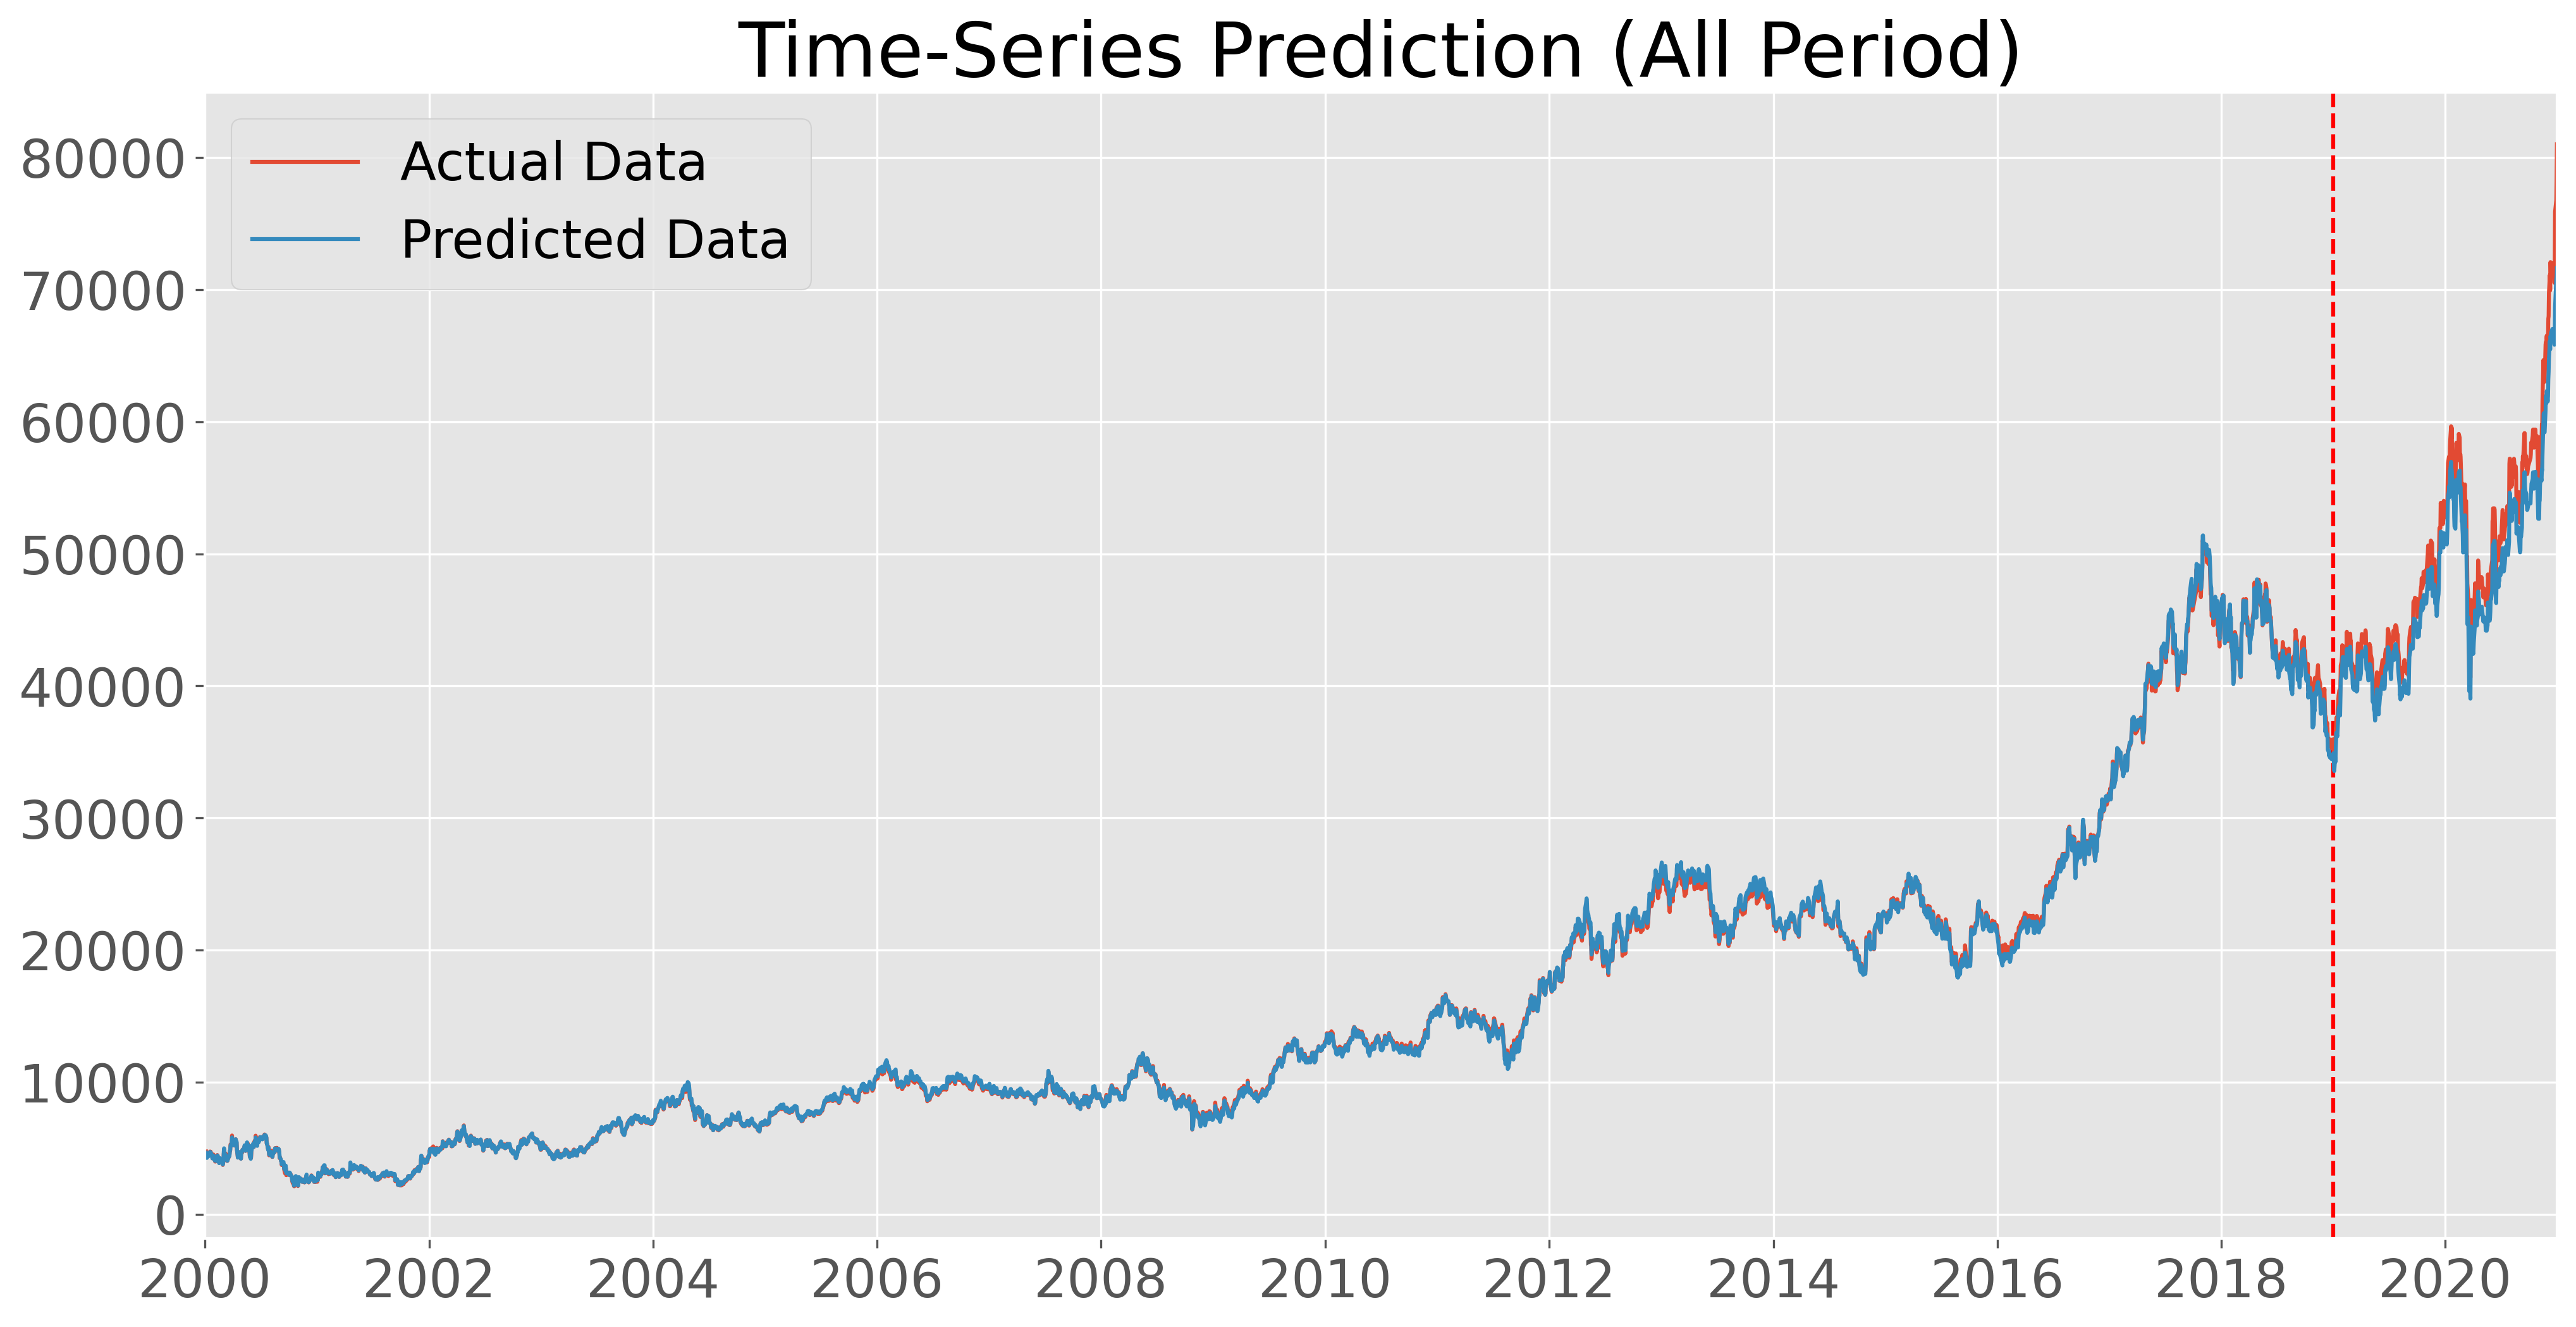

In [24]:
X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y) 

df_X = Variable(torch.Tensor(X_data)) #converting to Tensors
df_y = Variable(torch.Tensor(y_data))
#reshaping the dataset
df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))
train_predict = pl_gru(df_X.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y.data.numpy()

data_predict = MMS.inverse_transform(data_predict) #reverse transformation
dataY_plot = MMS.inverse_transform(dataY_plot)

plt.xlim(datetime.datetime(2000, 1, 1), datetime.datetime(2020, 12, 31))
test_line = datetime.datetime(2019, 1, 1)
plt.axvline(x=test_line, c='r', linestyle='--') #size of the training set

plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), data_predict, label='Predicted Data') # plot for predicted data
plt.title('Time-Series Prediction (All Period)')
plt.legend()
plt.savefig('images/prediction_base_all_gru.pdf', bbox_inches='tight')
plt.show() 

In [25]:
MSE = float(sum((dataY_plot - data_predict)*(dataY_plot - data_predict))/len(data_predict))
print('Mean Squared Error:', MSE)

Mean Squared Error: 561357.6875


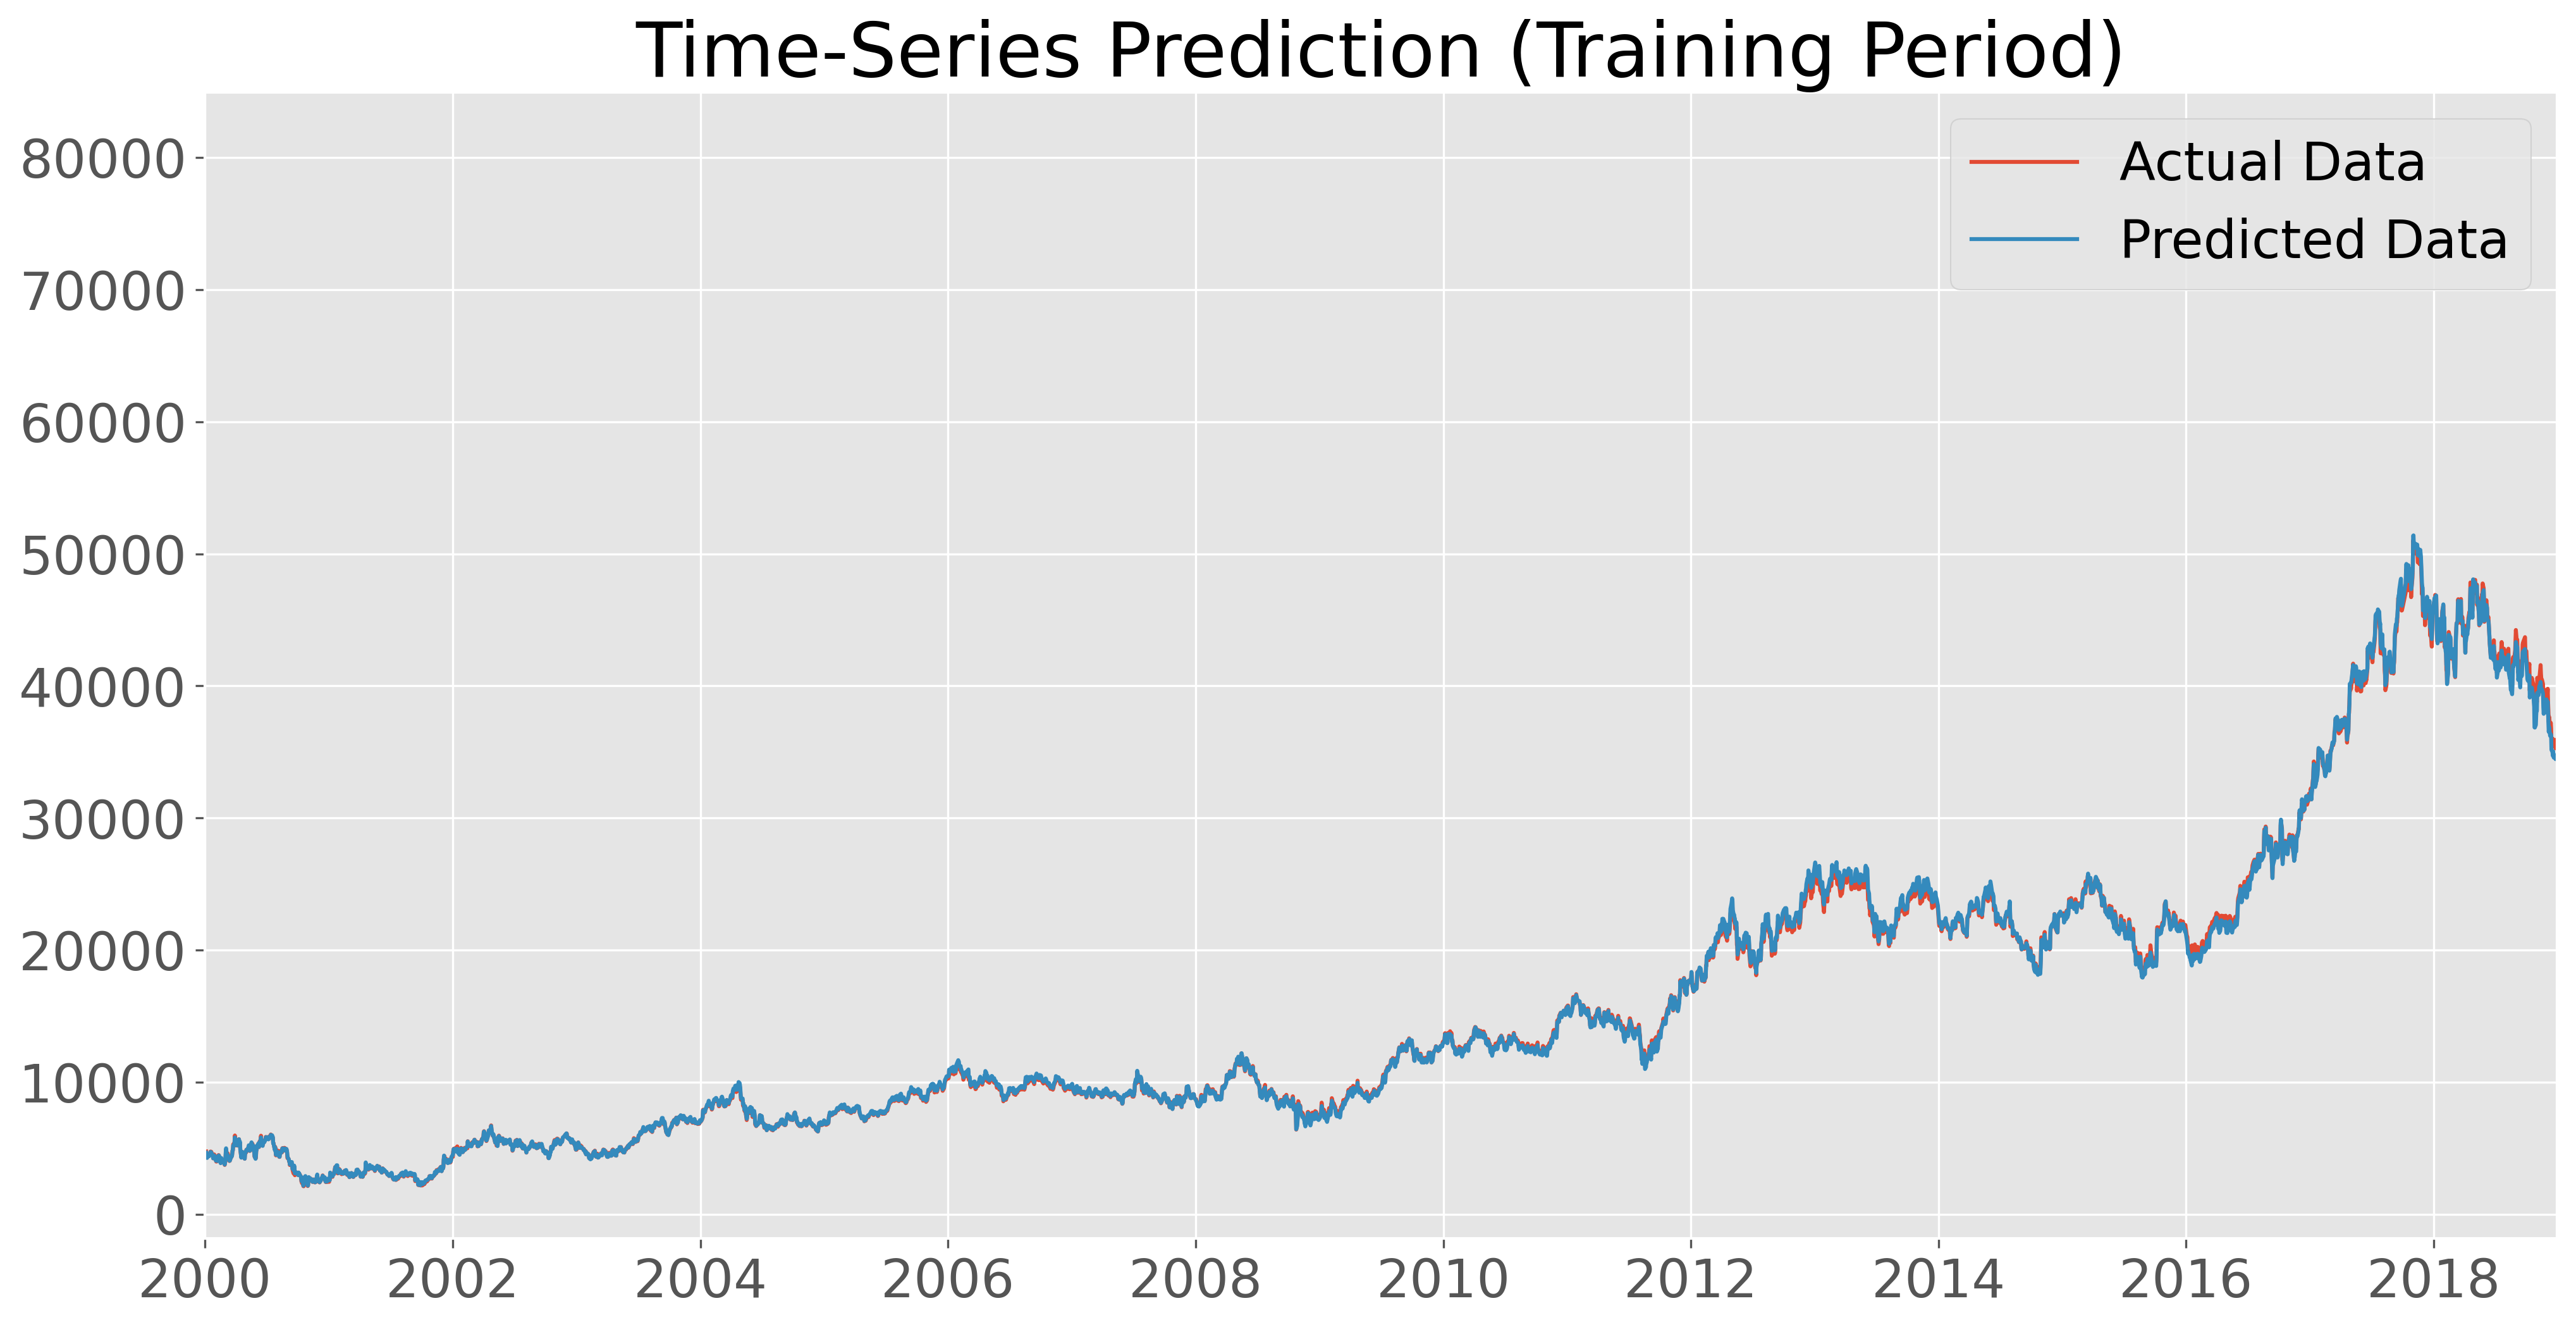

In [15]:

plt.xlim(datetime.datetime(2000, 1, 1), datetime.datetime(2018, 12, 31))
plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), data_predict, label='Predicted Data') # plot for predicted data
plt.title('Time-Series Prediction (Training Period)')
plt.legend()
plt.savefig('images/prediction_base_train_gru.pdf', bbox_inches='tight')
plt.show() 

In [16]:
MSE_train = float(sum((dataY_plot[0:4780] - data_predict[0:4780])*(dataY_plot[0:4780] - data_predict[0:4780]))/len(data_predict[0:4780]))
print('Mean Squared Error (Training Data):', MSE_train)

Mean Squared Error (Training Data): 51174.46875


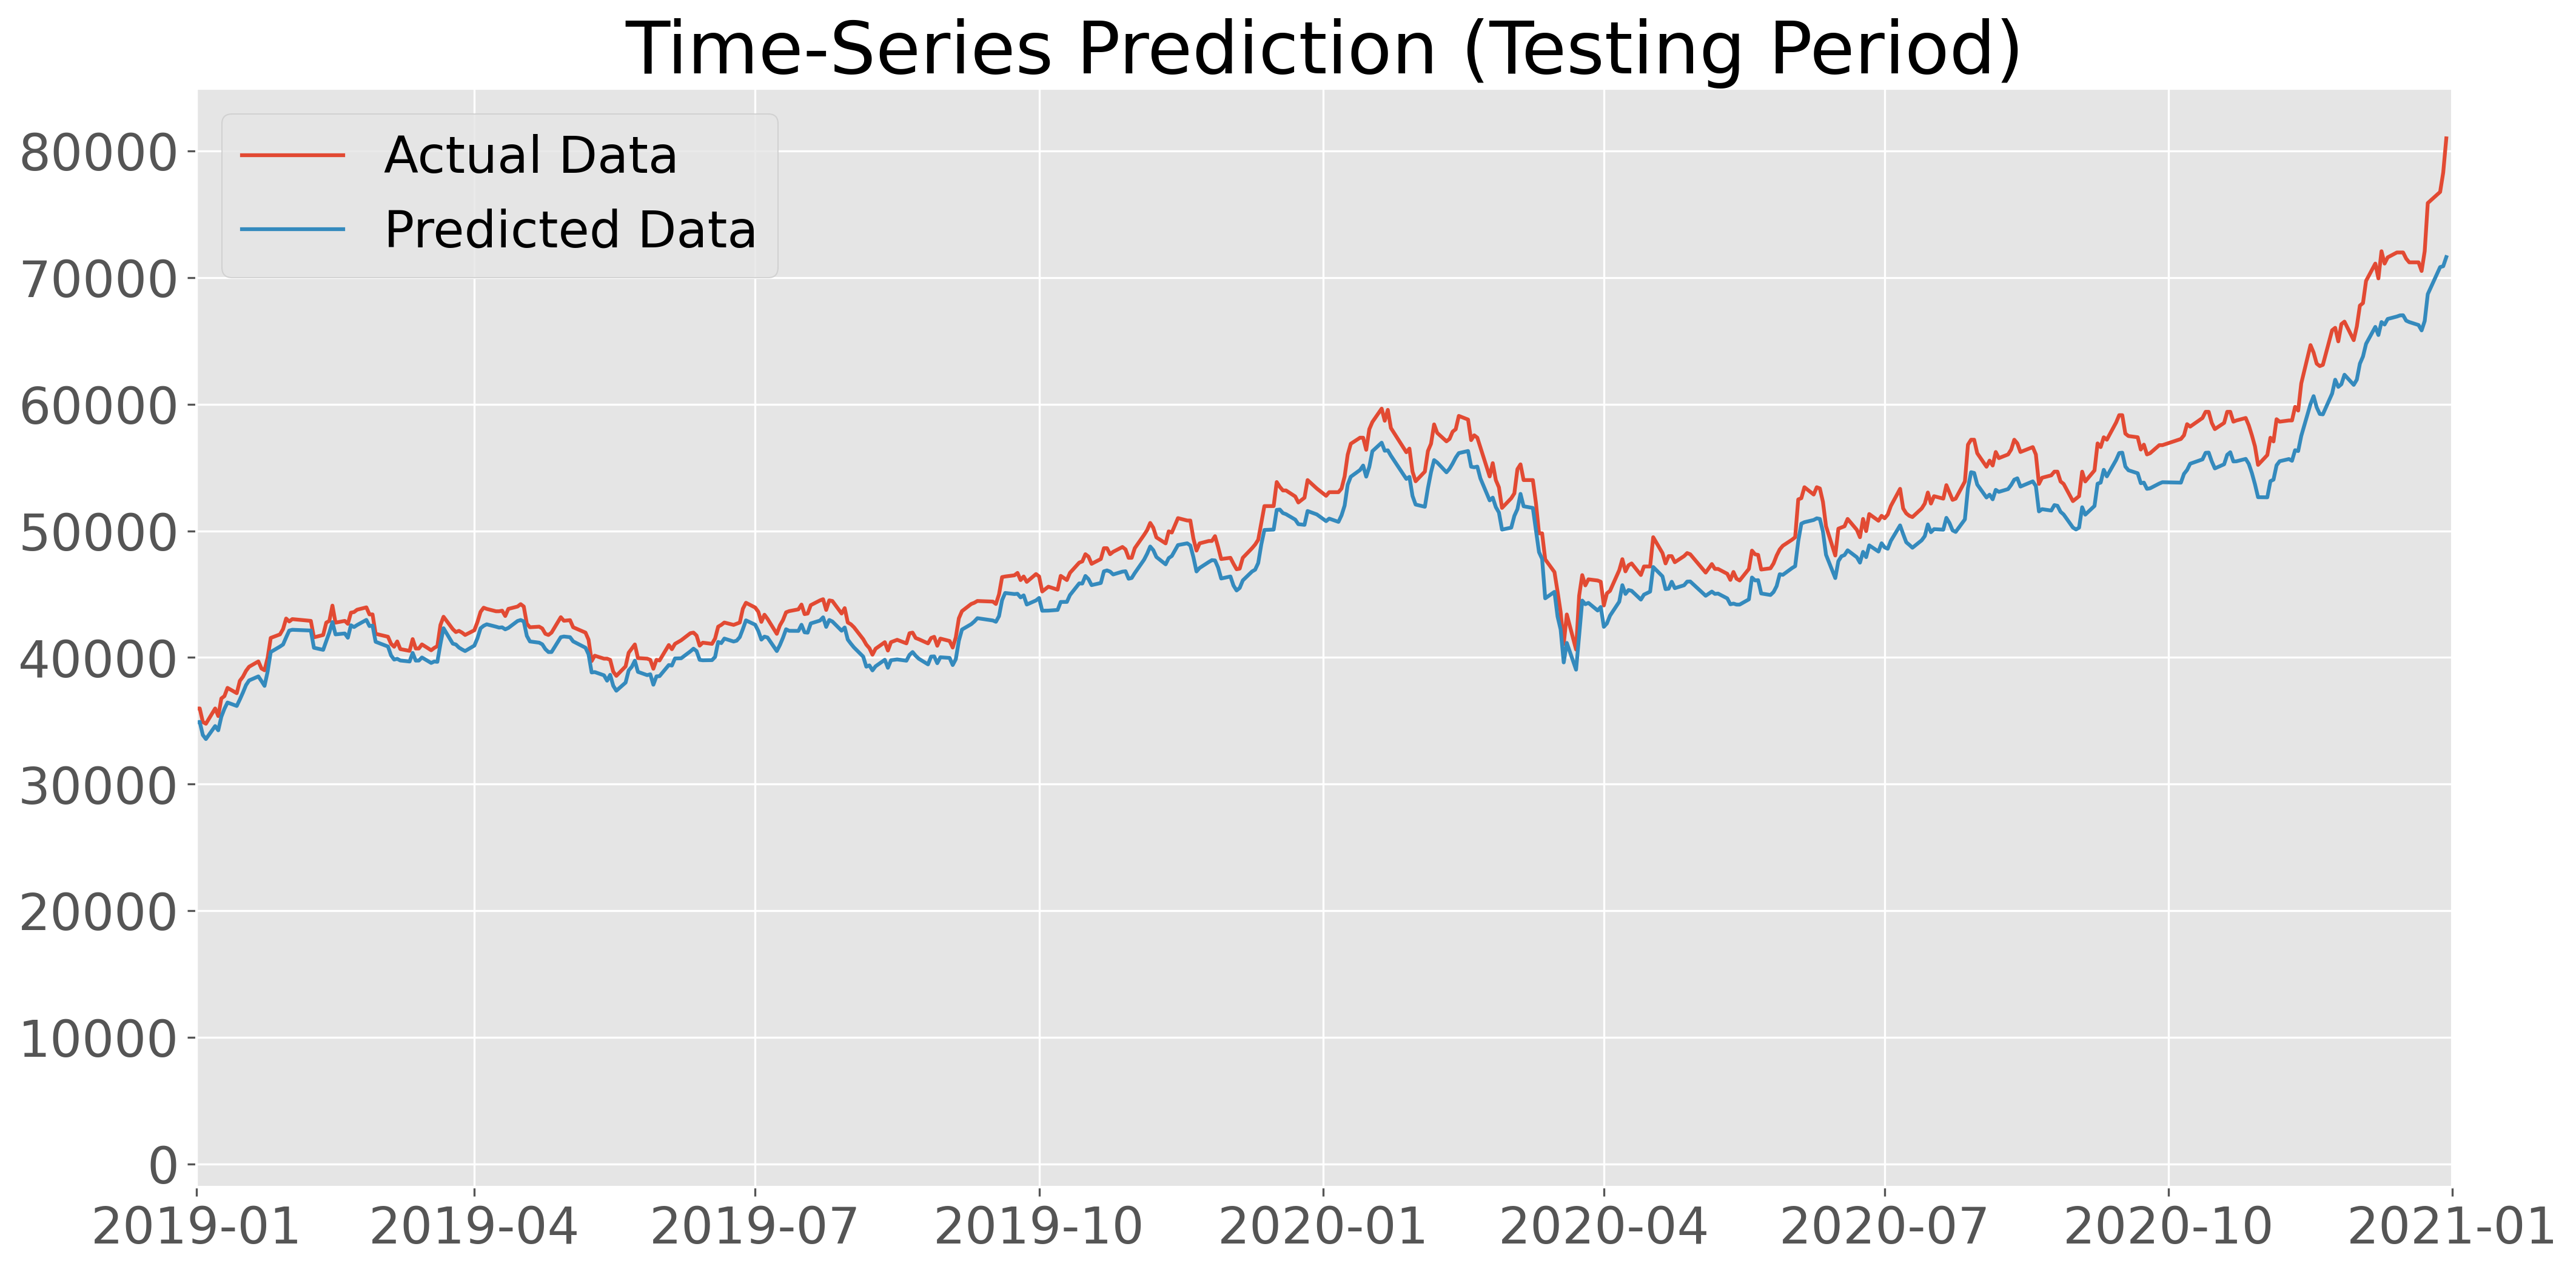

In [17]:
plt.xlim(datetime.datetime(2019, 1, 1), datetime.datetime(2021, 1, 1))
plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), data_predict, label='Predicted Data', color='green') # plot for predicted data
plt.title('Time-Series Prediction (Testing Period)')
plt.legend()
plt.savefig('images/prediction_base_test_gru.pdf', bbox_inches='tight')
plt.show()

In [18]:
MSE_test = float(sum((dataY_plot[4780:] - data_predict[4780:])*(dataY_plot[4780:] - data_predict[4780:]))/len(data_predict[4780:]))
print('Mean Squared Error (Test Data):', MSE_test)

Mean Squared Error (Test Data): 5497948.0


### Saving learned model

In [27]:
with torch.no_grad():
    torch.save(GRU, 'saved_models/samsung_gru.pt')

## Comparison with LSTM

In [28]:
class LSTM_model(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM_model, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #LSTM layer
    self.fc = nn.Linear(hidden_size, num_classes) #fully connected last layer

  def forward(self,x):
    h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
    # Decode the hidden state of the last time step
    out = self.fc(out[:, -1, :])
    return out

# Load trained LSTM
lstm = torch.load('saved_models/samsung_lstm.pt')

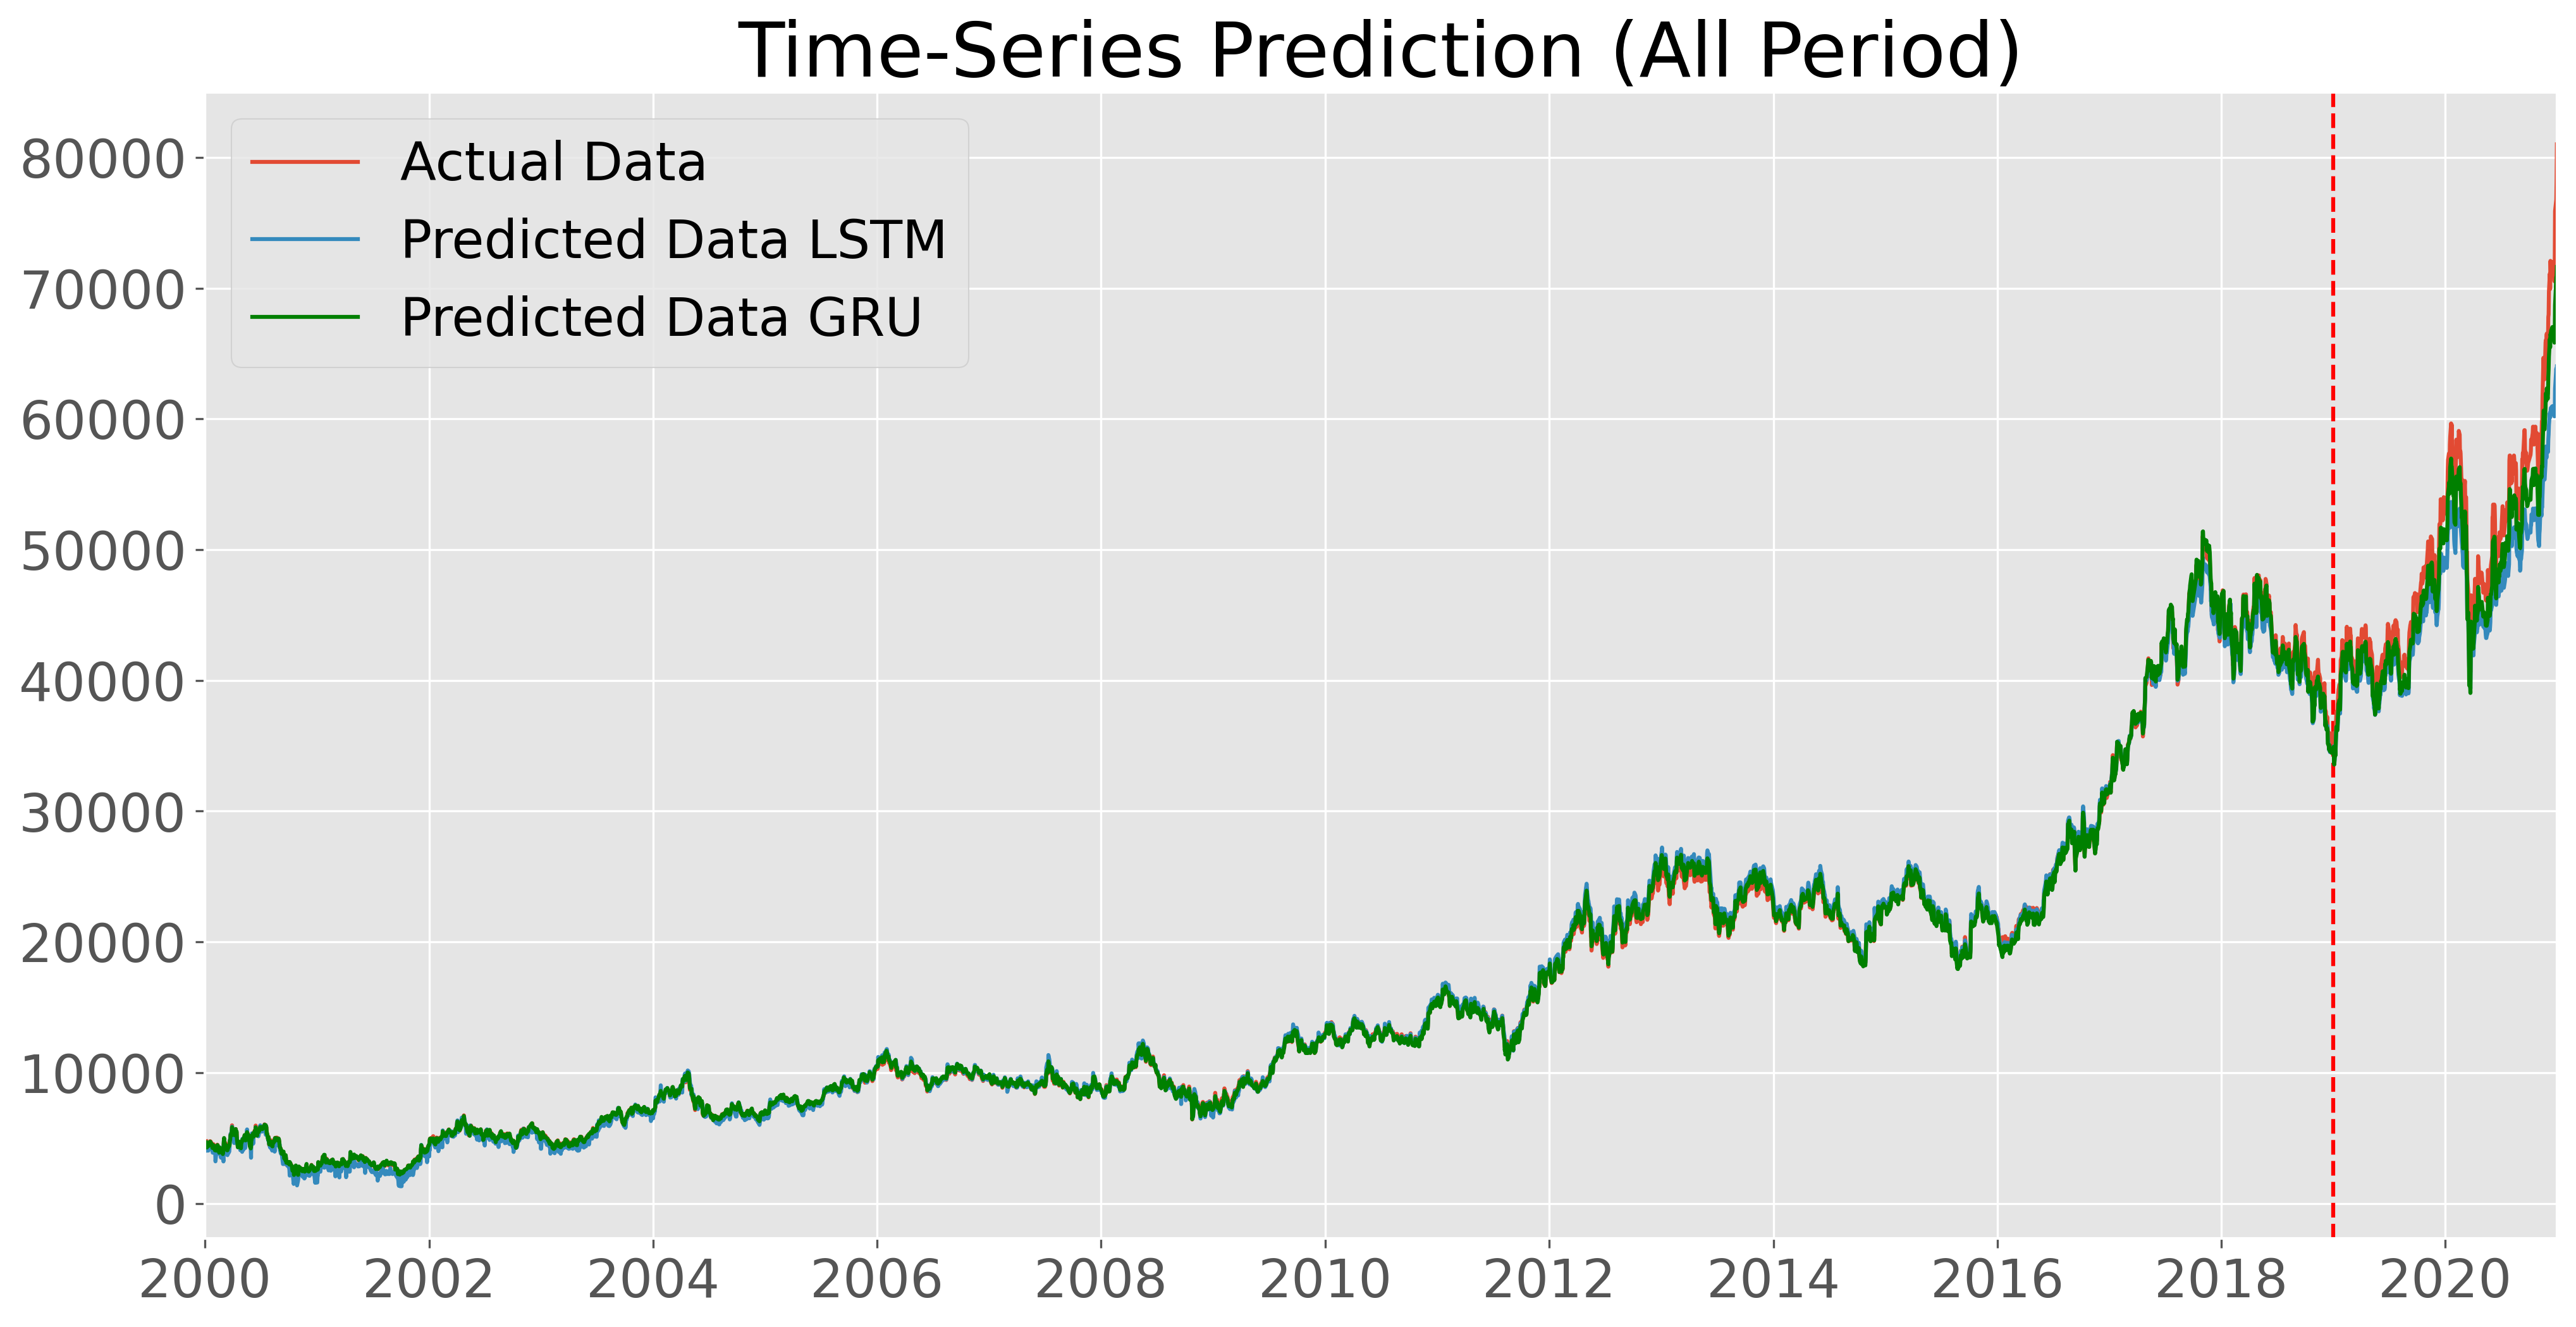

In [29]:
# Load LSTM predictions
X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y) 

df_X = Variable(torch.Tensor(X_data)) #converting to Tensors
df_y = Variable(torch.Tensor(y_data))

df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))
train_predict = lstm(df_X.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y.data.numpy()
data_predict_lstm = MMS.inverse_transform(data_predict) #reverse transformation
dataY_plot = MMS.inverse_transform(dataY_plot)

# Load GRU predictions
X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y) 

df_X = Variable(torch.Tensor(X_data)) #converting to Tensors
df_y = Variable(torch.Tensor(y_data))
df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))
train_predict = pl_gru(df_X.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y.data.numpy()
data_predict_gru = MMS.inverse_transform(data_predict) #reverse transformation
dataY_plot = MMS.inverse_transform(dataY_plot)

plt.xlim(datetime.datetime(2000, 1, 1), datetime.datetime(2020, 12, 31))
test_line = datetime.datetime(2019, 1, 1)
plt.axvline(x=test_line, c='r', linestyle='--') #size of the training set

plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), data_predict_lstm, label='Predicted Data LSTM') # plot for predicted data
plt.plot(df.index.to_pydatetime(), data_predict_gru, label='Predicted Data GRU', color='green') # plot for predicted data
plt.title('Time-Series Prediction (All Period)')
plt.legend()
plt.savefig('images/prediction_base_all_lstm_gru.pdf', bbox_inches='tight')
plt.show() 

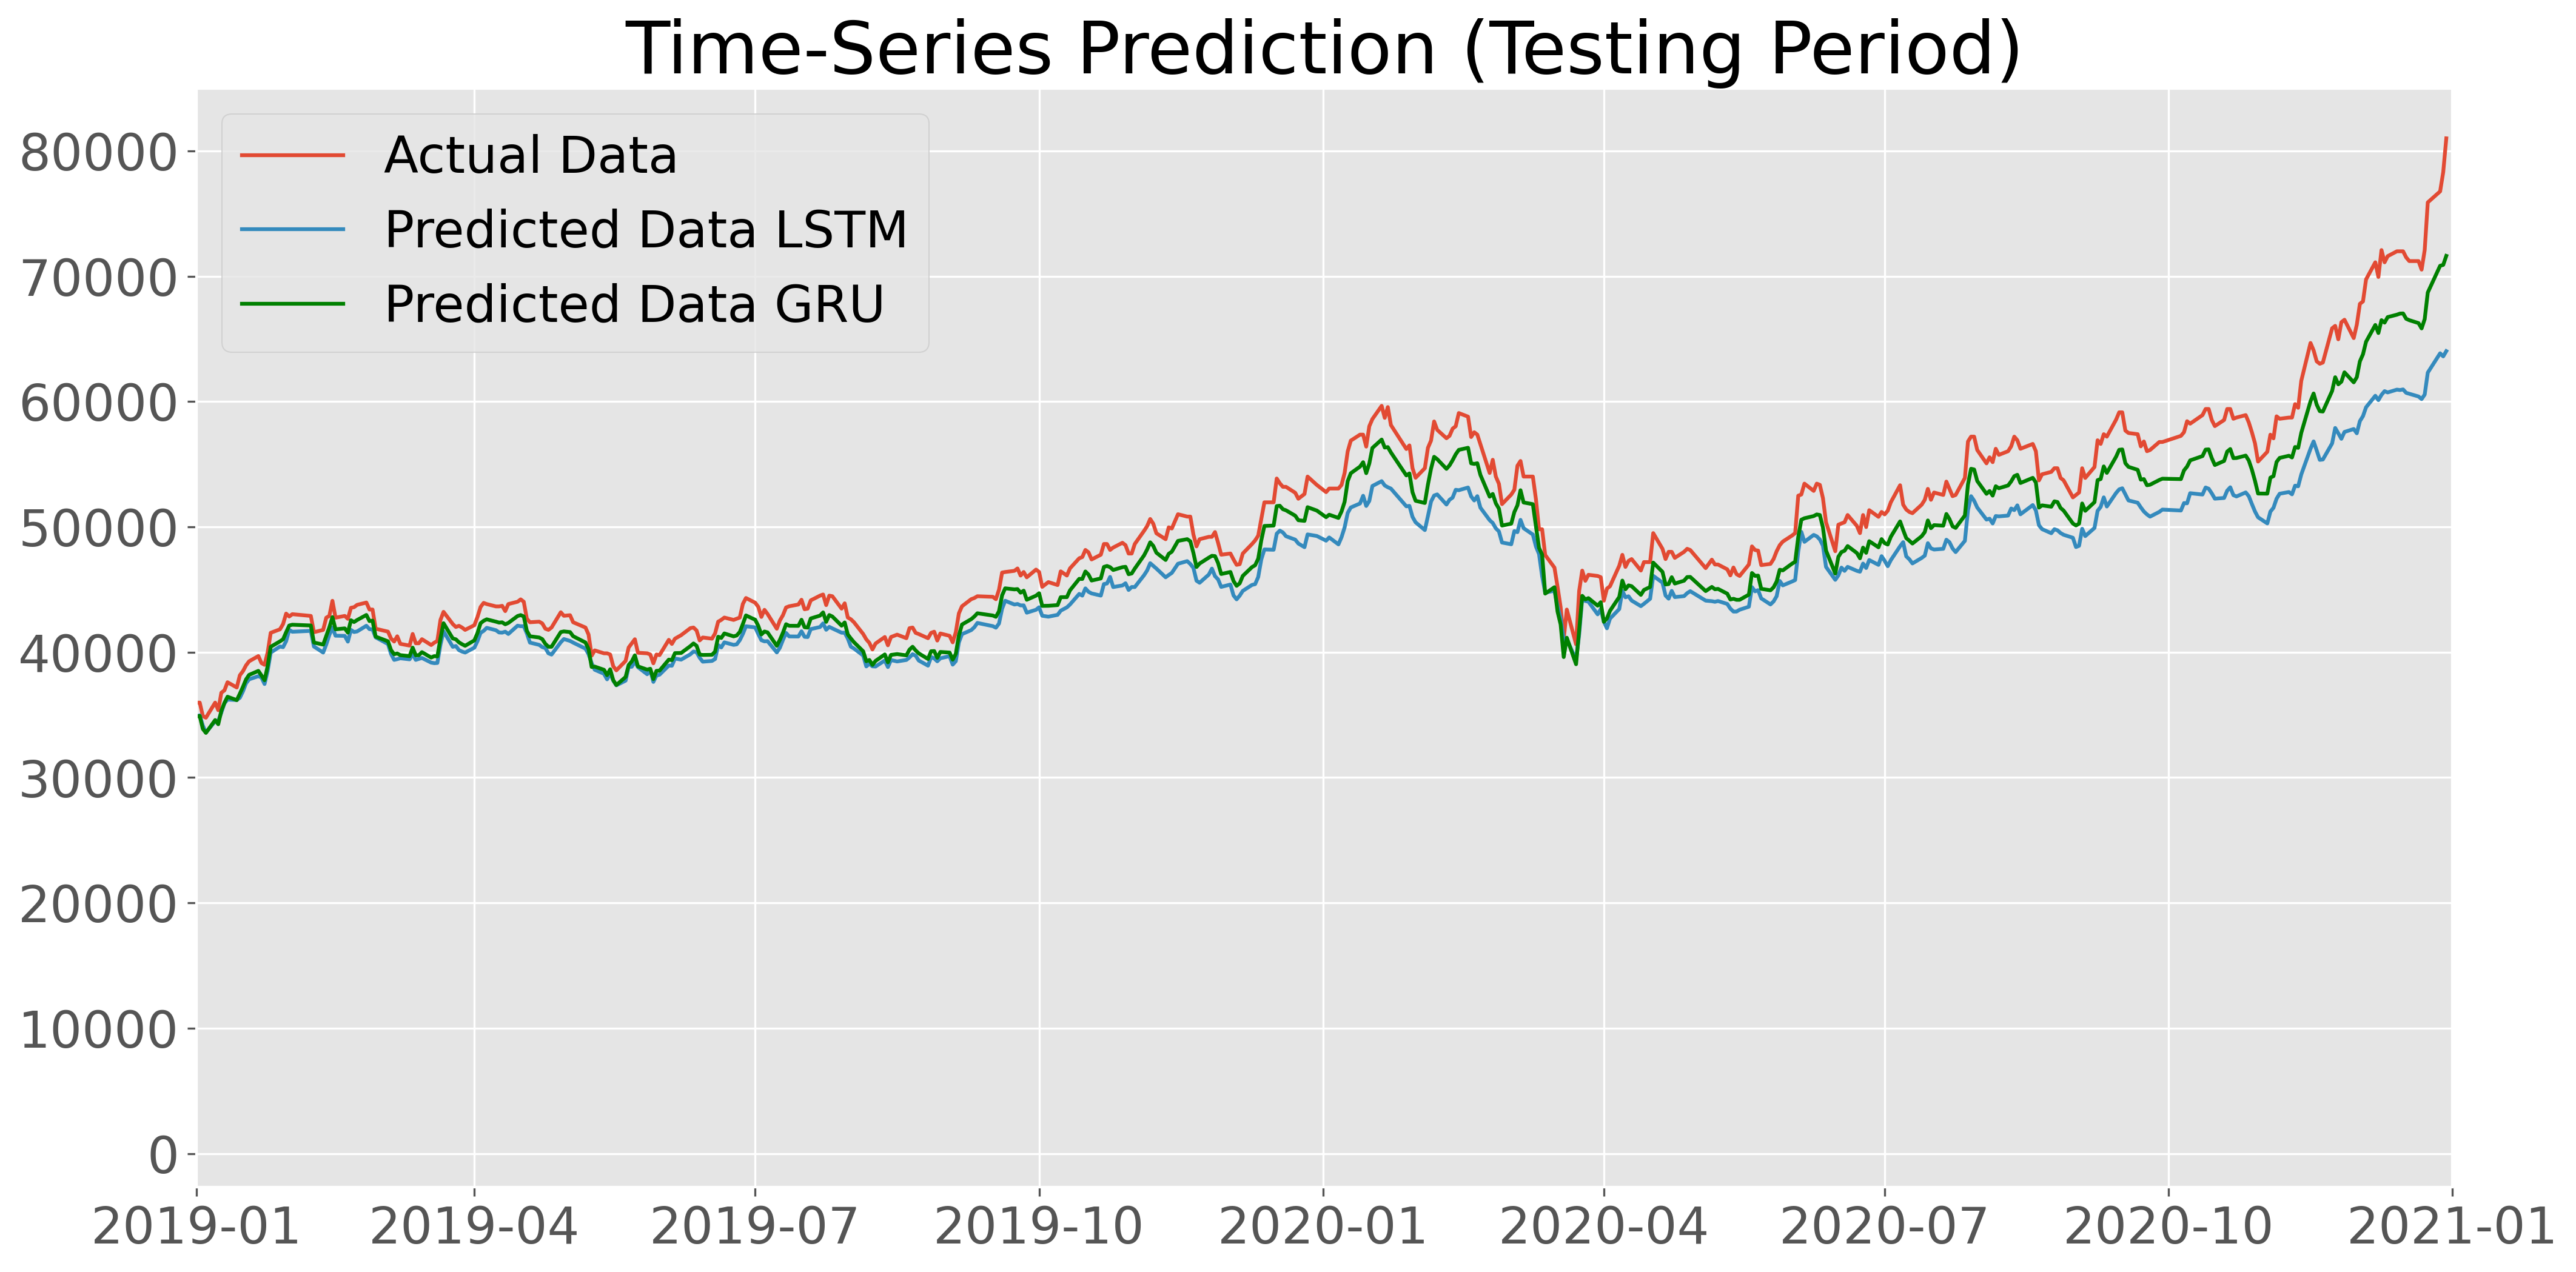

In [31]:
plt.xlim(datetime.datetime(2019, 1, 1), datetime.datetime(2021, 1, 1))
plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), data_predict_lstm, label='Predicted Data LSTM') # plot for predicted data
plt.plot(df.index.to_pydatetime(), data_predict_gru, label='Predicted Data GRU', color='green') # plot for predicted data
plt.title('Time-Series Prediction (Testing Period)')
plt.legend()
plt.savefig('images/prediction_base_test_lstm_gru.pdf', bbox_inches='tight')
plt.show()